In [1]:
'''
author: Yike Xie
data: 30/03/2022
content: correlate image features and exon transcriptome
'''

'\nauthor: Yike Xie\ndata: 30/03/2022\ncontent: correlate image features and exon transcriptome\n'

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from matplotlib import rcParams

In [3]:
def sg_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter adata of single cells')
    adata_s = adata[adata.obs_names.isin(features.index)]

    print('filter genes')
    sc.pp.filter_genes(adata_s, min_cells=10)

    print('Add features to adata')
    for col in ['area', 'length', 'width', 'eccentricity', 'spectrum', 'wavelengths']:
        adata_s.obs[col] = features.loc[adata_s.obs_names][col]
    
    return adata_s

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/' + 'features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/exon_filter.h5ad'
adata_s = sg_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'

load features
load dataset
filter adata of single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


filter genes


Trying to set attribute `.var` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Add features to adata


In [105]:
# dataset with gene name as var_names
adata_g = adata_s.copy()
adata_g.var = adata_g.var.reset_index().set_index('gene_name')

1

In [106]:
# fraction of exons inside the correspond genes
exon_fra = []
exon_ls = adata_s.var_names
for exon in exon_ls[:-4]:
    gene = adata_s.var.loc[exon]['gene_name']
    e_exp = adata_s[:, exon].X.sum(axis=1)
    g_exp = adata_g[:, gene].X.sum(axis=1)
    fra = [i/(j+0.001) for i, j in zip(e_exp, g_exp)]
    exon_fra.append(fra) 
    
exon_fra_df = pd.DataFrame(exon_fra, index=exon_ls[:-4], columns=adata_s.obs_names)
exon_fra_df.to_csv(save_figures + 'exon_fraction.tsv', sep='\t')

1

In [126]:
g_exp1 = adata_g[:, gene].X.sum(axis=1)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [127]:
e_exp1 = adata_s[:, exons].X.sum(axis=1)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [67]:
# filter out exons with 0 expression
adata_e = adata_s[:, (adata_s.X > 0).sum(axis=0) > 0]

# get dataframe with the expression of exons and number of cells expressing the exon
exon_n = pd.DataFrame((adata_e.X > 0).sum(axis=0), index=adata_e.var_names, columns=['exon_n'])
exon_n['exon_exp'] = adata_e.X.sum(axis=0)
exon_n['gene_name'] = adata_e.var['gene_name']
exon_n = exon_n[:-4]

exon_n = exon_n[exon_n['exon_n'] >=70]

# filter out genes with at least two exons
ft_g = exon_n.groupby('gene_name').size().sort_values(ascending=False).to_frame()
ft_g = ft_g[ft_g[0] >=2 ]
ft_g = ft_g[ft_g.index != '']

exon_n = exon_n[exon_n['gene_name'].isin(ft_g.index)]
exon_n = exon_n.reset_index().set_index('exon_id')

In [82]:
print('Correlate with some simple features')
feas = ['area']
labels = ['Area [$px^2$]']

phe = adata_s[:, exon_n.index].obs[feas].fillna(0)

x = exon_fra_df.loc[exon_n.index].values #(39466, 10)
y = phe.values.T #(2, 10)

from scipy.stats import rankdata

xw = np.zeros_like(x, float)
for ii, xi in enumerate(x):
    xw[ii] = rankdata(xi, method='average')
yw = np.zeros_like(y, float)
for ii, yi in enumerate(y):
    yw[ii] = rankdata(yi, method='average')
    
xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
n = xw.shape[1]
r = np.dot(xw, yw.T) / n

corr = pd.DataFrame(
                data=r,
                index=adata_s[:, exon_n.index].var_names,
                columns=phe.columns,
                dtype=float)

corr['gene_name'] = adata_s.var.loc[corr.index]['gene_name']
corr['exon_number'] = adata_s.var.loc[corr.index]['exon_number']

corr.to_csv(save_figures + 'area_exon_fra.tsv', sep='\t')

Correlate with some simple features


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


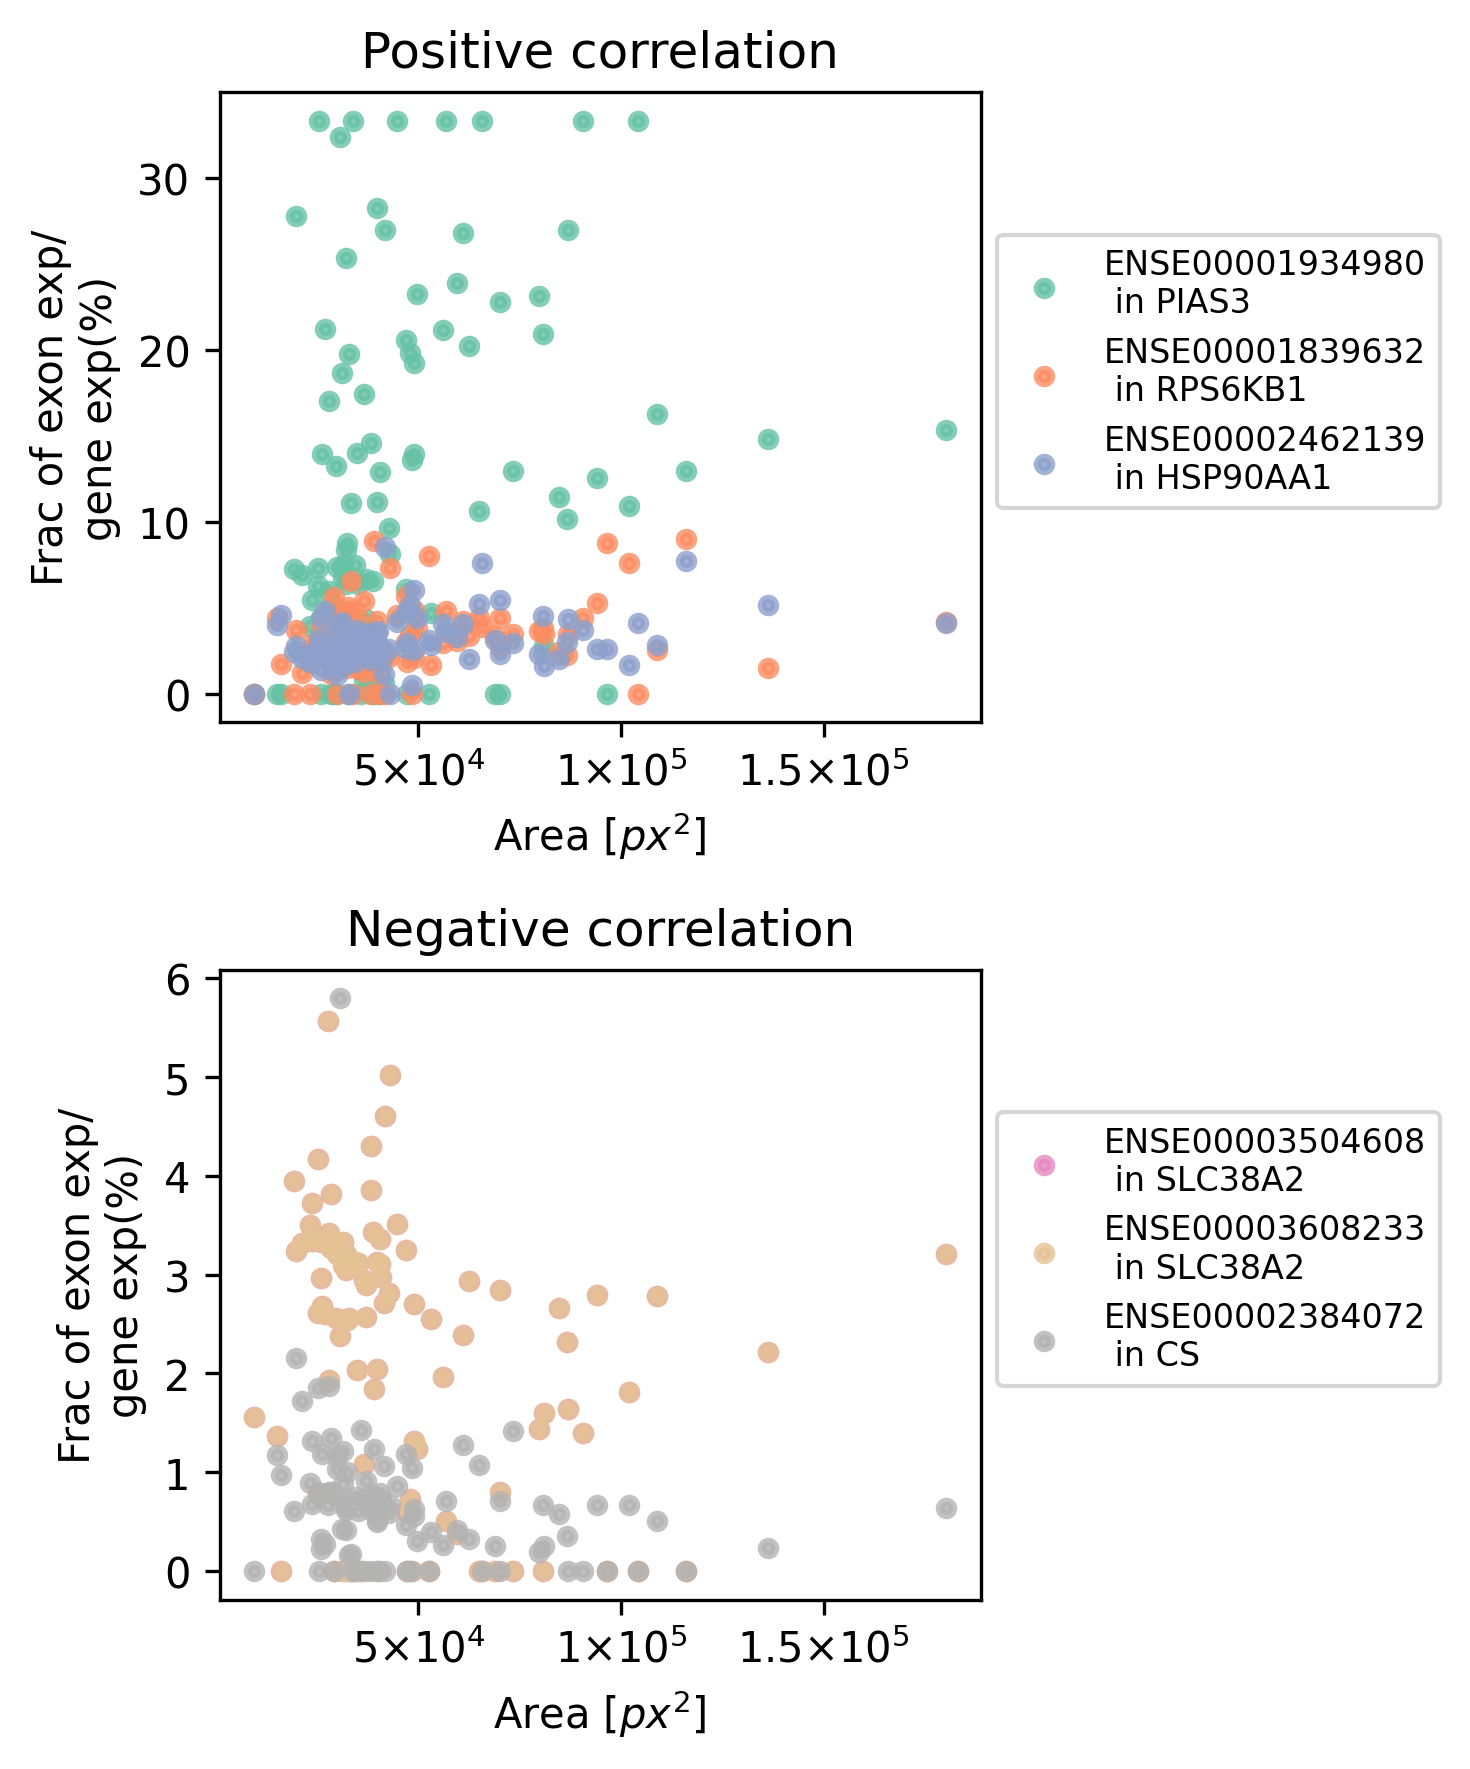

In [83]:
feas = ['area']
labels = ['Area [$px^2$]']

n_exons = 3
colors = sns.color_palette('Set2', 8)[:4] + sns.color_palette('Set2', 8)[-2:]
colors = [colors[: n_exons], colors[n_exons:]]

fig, axs = plt.subplots(2, 1, figsize=(5, 6), dpi=300)
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"

fea = feas[0]
exons_both = [
        corr.nlargest(n_exons, fea).index.tolist(),
        corr.nsmallest(n_exons, fea).index.tolist(),
    ]
for j, (ax, exons) in enumerate(zip(axs, exons_both)):
    for ie, exon in enumerate(exons):
        x = adata_s.obs[fea]
        y = exon_fra_df.loc[exon]
        g = corr.loc[exon]['gene_name']
        idx = np.argsort(x)
        ax.scatter(
            x[idx], y[idx] * 100, alpha=0.8, lw=2, color=colors[j][ie], s=10, label=f'{exon}\n in {g}'
        )
        
    ax.legend(fontsize=8, bbox_to_anchor=(1, 0.8))
    ax.set_xlabel(labels[0])
    ax.set_ylabel('Frac of exon exp/\ngene exp(%)')
    ax.set_xlim(ax.get_xlim())
    xticks = [50000, 100000, 150000]
    xticklabels = ['5×$10^4$', '1×$10^5$', '1.5×$10^5$', ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
            
    #ax.grid(True)
axs[0].set_title('Positive correlation')
axs[1].set_title('Negative correlation')
fig.tight_layout()

plt.savefig(save_figures + 'area_exon_fra.png')
plt.savefig(save_figures + 'area_exon_fra.pdf')

<ipython-input-133-c6ee9631b245>:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


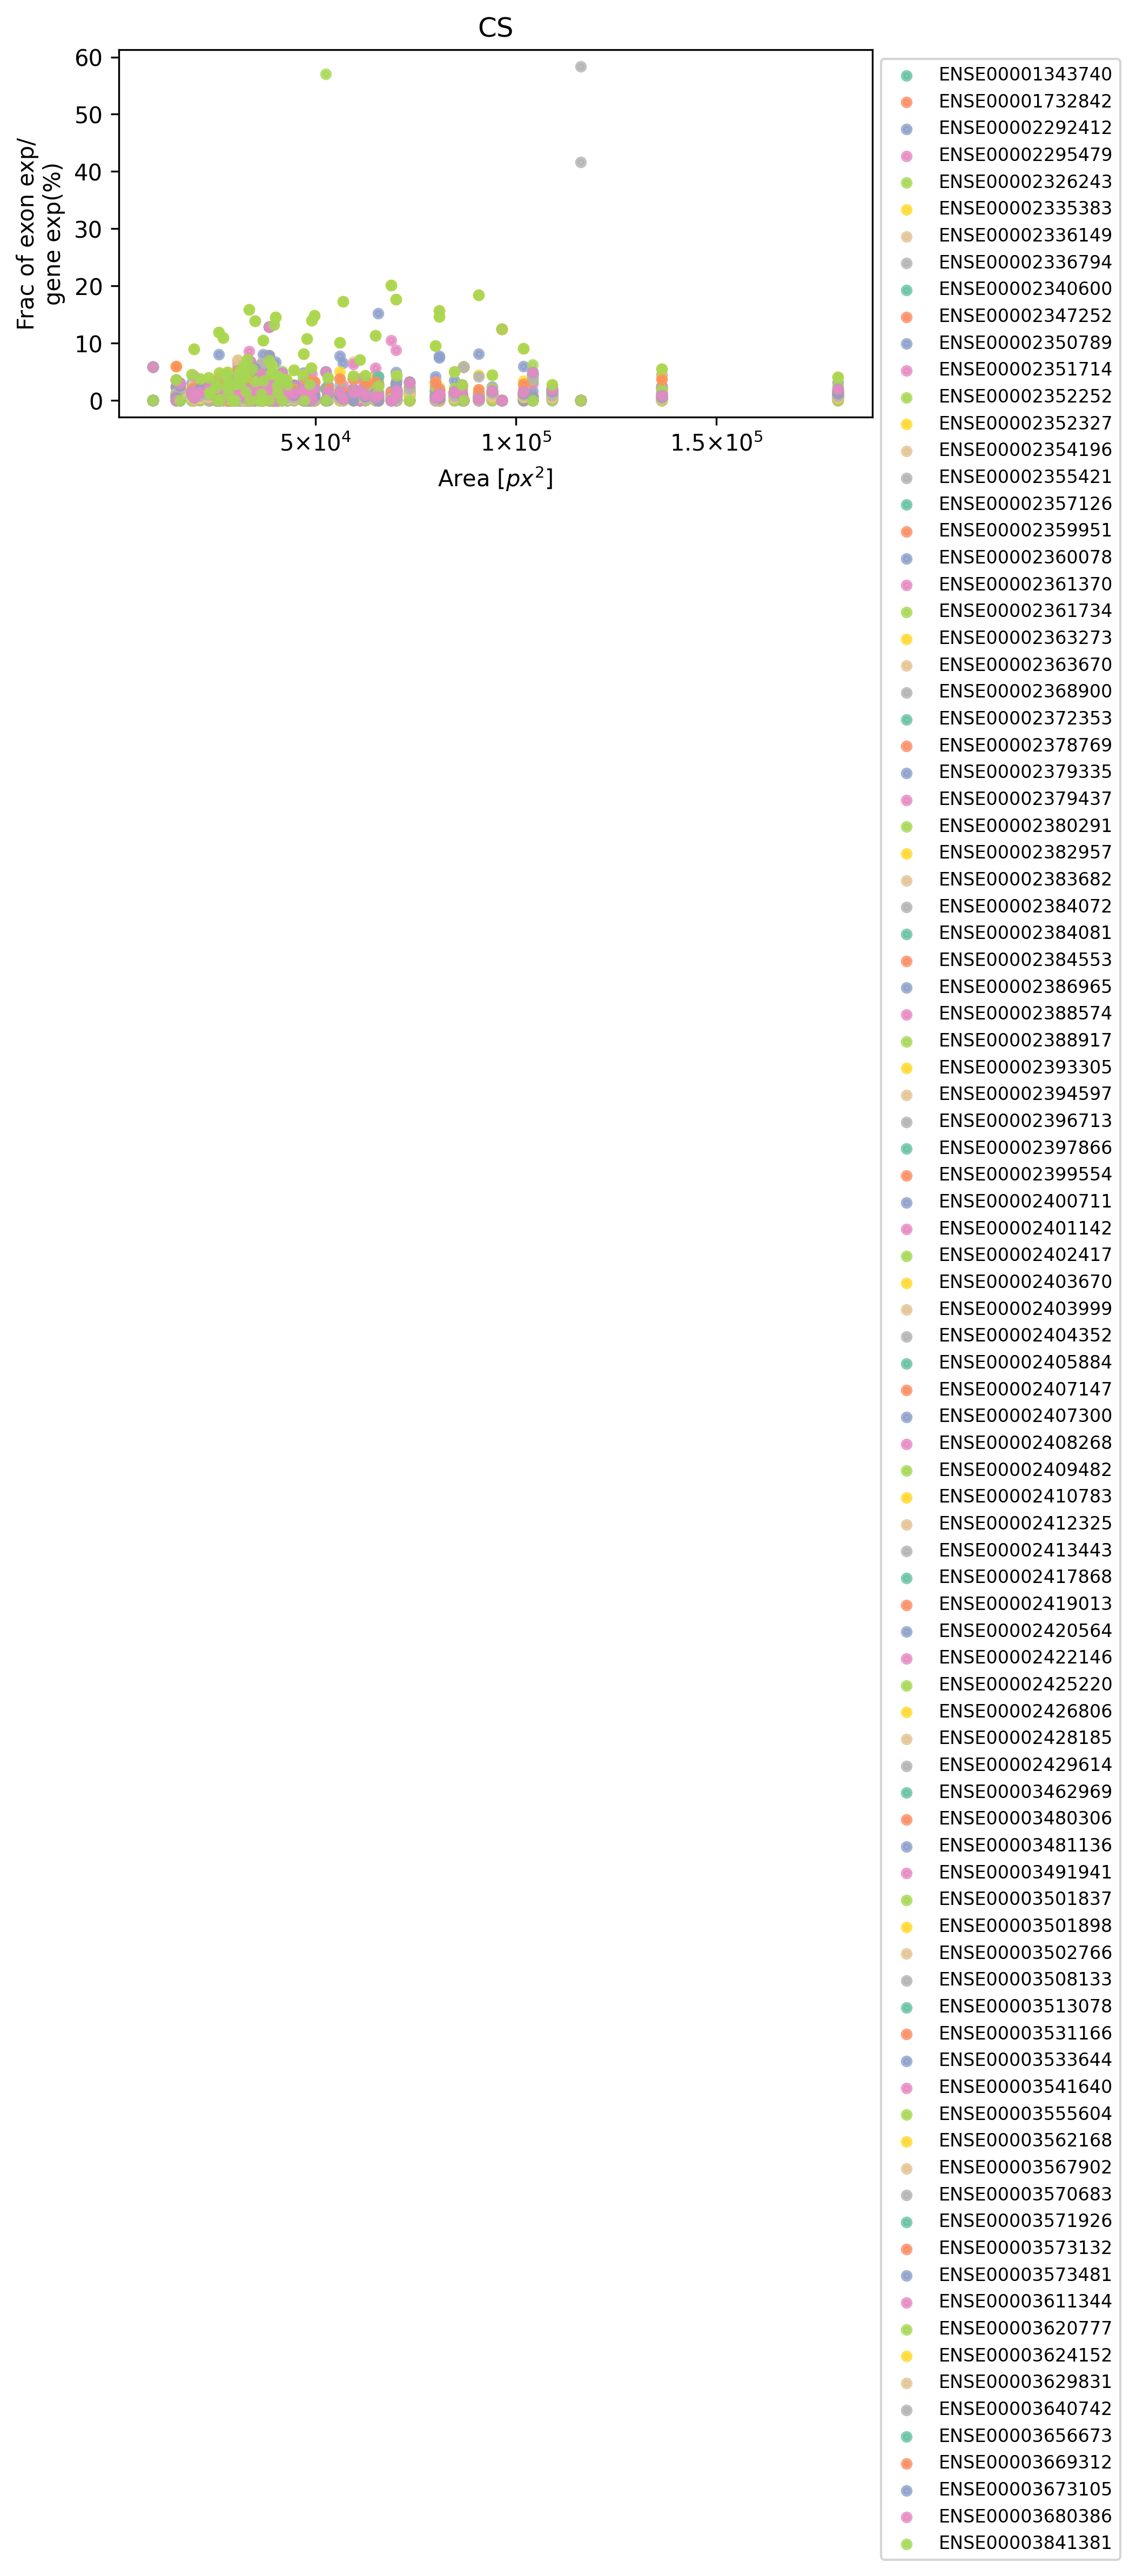

In [133]:
# write a function plot the frac vs area of all exons in a gene
feas = ['area']
labels = ['Area [$px^2$]']
gene = 'CS'

exons = adata_g.var.loc[gene]['exon_id']

colors = sns.color_palette('Set2', len(exons))

fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"

fea = feas[0]
x = adata_s.obs[fea]
idx = np.argsort(x)
for i, exon in enumerate(exons):
    y = exon_fra_df.loc[exon]
    ax.scatter(
        x[idx], y[idx] * 100, alpha=0.8, lw=2, color=colors[i], s=10, label=exon
    )

ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
ax.set_xlabel(labels[0])
ax.set_ylabel('Frac of exon exp/\ngene exp(%)')

ax.set_xlim(ax.get_xlim())
xticks = [50000, 100000, 150000]
xticklabels = ['5×$10^4$', '1×$10^5$', '1.5×$10^5$', ]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
            
#ax.grid(True)
ax.set_title(gene)
fig.tight_layout()

# plt.savefig(save_figures + 'area_exon_fra.png')
# plt.savefig(save_figures + 'area_exon_fra.pdf')